<a href="https://colab.research.google.com/github/maxi9113/BigDataCNN20251695010/blob/main/20251695010_taller_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargamos todos los archivos en para procesar las imagenes del repo objetos_salon

In [1]:
import requests
import os

# GitHub repository details
github_repo = "Gerardo-cursos/objetos_salon"
github_api_url = f"https://api.github.com/repos/{github_repo}/contents/processed"

# Folders to download images from
folders = ["cpu", "mesa", "mouse", "nada", "pantalla", "silla", "teclado"]

# Create the /content/ directory if it doesn't exist
if not os.path.exists("/content/"):
    os.makedirs("/content/")

# Iterate through each folder and download images
for folder in folders:
    folder_url = f"{github_api_url}/{folder}"
    response = requests.get(folder_url)

    if response.status_code == 200:
        files = response.json()
        for file in files:
            if file['type'] == 'file' and file['name'].endswith(('.png', '.jpg', '.jpeg')):
                image_url = file['download_url']
                image_name = file['name']
                # Prepend the folder name to the image filename
                new_image_name = f"{folder}_{image_name}"
                image_path = os.path.join("/content/", new_image_name)

                # Download the image
                image_response = requests.get(image_url)
                if image_response.status_code == 200:
                    with open(image_path, 'wb') as f:
                        f.write(image_response.content)
                else:
                    print(f"Failed to download: {image_url}")
    else:
        print(f"Failed to access folder: {folder_url}")

print("Image download complete.")

Image download complete.


**Reasoning**:
Creamos las caracteristicas de todas la imagenes descargadas en la carpeta content y tambien generamos un vector con la etiqueta de cada imagen

In [2]:
import numpy as np
import cv2
import os
folders = ["cpu", "mesa", "mouse", "nada", "pantalla", "silla", "teclado"]

# Create a list of all the saved frame filenames
all_files = os.listdir('/content/')
saved_frames = [f for f in all_files ]

# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate through the list of frame filenames
for frame_filename in saved_frames:
    print(frame_filename)
    # Construct the full image path
    image_path = os.path.join('/content/', frame_filename)

    # Read the image file
    image = cv2.imread(image_path)

    if image is not None:
        # Extract the label from the filename
        coincidencias = [p for p in folders if p in frame_filename.lower()]

        label = coincidencias

        # Resize the image to a consistent size (e.g., 128x128 pixels)
        resized_image = cv2.resize(image, (128, 128))

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Normalize the pixel values
        normalized_image = gray_image / 255.0

        # Append the processed image and label to the lists
        images.append(normalized_image)
        labels.append(label)
    else:
        print(f"Warning: Could not read image file {image_path}")


# Convert the lists to NumPy arrays
images_array = np.array(images)
labels_array = np.array(labels)



.config
pantalla_20251695004_pantalla_0010.png
silla_20242595003_silla_0028.png
pantalla_20252695006__pantalla_0008.jpg
nada_20251695007_nada_009.png
cpu_20242595003_cpu_0006.png
cpu_20251695007_CPU_020.png
silla_20242695004_silla_0001.jpg
silla_20242595003_silla_0041.png
mouse_20242595003_mouse_0032.png
cpu_20252695008_0015.jpg
silla_20242695004_silla_0002.jpg
mesa_20241695014_mesa_0005.png
nada_20242595004_nada_0005.png
silla_20242595003_silla_0003.png
cpu_20252695004_cpu_0005.jpg
silla_20242595003_silla_0038.png
mouse_20242695004_mouse_0006.jpg
mesa_20252695008_0014.jpg
silla_20242595003_silla_0037.png
silla_20252695004_silla_0006.jpg
mesa_20252695008_0007.jpg
silla_20242595003_silla_0035.png
mesa_20252695008_0001.jpg
pantalla_20242595005_4.jpg
mouse_20251695007_mouse_008.png
cpu_20252695006_cpu_0005.jpg
mouse_20251695007_mouse_015.png
mouse_20251595004_mouse_07.png
mouse_20251595004_mouse_04.png
mesa_20251695011_0003.jpg
pantalla_20251695004_pantalla_0003.png
cpu_20252695008_0010.j

In [3]:
print(f"Loaded and processed {len(images_array)} images.")
print(f"Images array shape: {images_array.shape}")
print(f"Labels array shape: {labels_array.shape}")

Loaded and processed 1792 images.
Images array shape: (1792, 128, 128)
Labels array shape: (1792, 1)



Diseñamos el modelo de autoenconder que vamos a usar para entrenar


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (128, 128, 1)

# Build the encoder
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Build the decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Sigmoid for output range [0, 1]

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse') # Using mse for pixel value reconstruction

# Print the model summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo de autoenconder

### Subtask:
Luego de definido el autoencoder se procede a entrenar el modelo con 20 epocas y 20 % de datos para test

In [5]:
# Reshape the images array to include the channel dimension
images_array_reshaped = np.expand_dims(images_array, axis=-1)

# Train the autoencoder
history = autoencoder.fit(images_array_reshaped, images_array_reshaped,
                          epochs=20,
                          validation_split=0.2)

print("Autoencoder training complete.")

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0535 - val_loss: 0.0115
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0098 - val_loss: 0.0074
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0

In [6]:
print("Pérdida final (entrenamiento):", history.history['loss'][-1])
print("Pérdida final (validación):", history.history['val_loss'][-1])

Pérdida final (entrenamiento): 0.003273616312071681
Pérdida final (validación): 0.003494293661788106


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


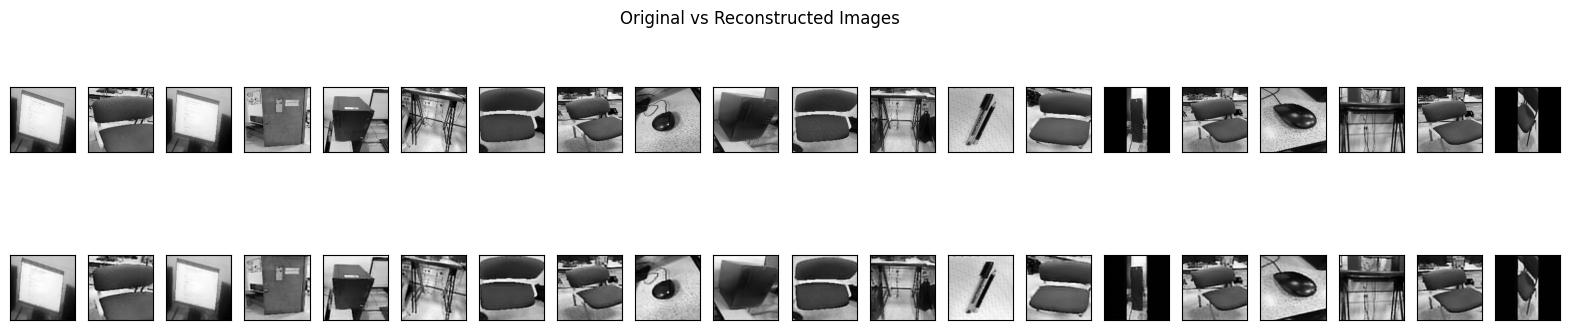

In [7]:
import matplotlib.pyplot as plt

# Use the trained autoencoder to predict reconstructed images
reconstructed_images = autoencoder.predict(images_array_reshaped)

# Display the first 20 original and reconstructed images
n = 20  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_array_reshaped[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle('Original vs Reconstructed Images')
plt.show()

## Construcción de modelo de clasificación

Construimos un modelo de clasificacion con las etiquetas que tenemos


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# --- Definir el encoder desde tu autoencoder ---
encoder = Model(inputs=autoencoder.input, outputs=encoded, name="encoder")
encoder.trainable = False  # CONGELAR encoder para no modificarlo

# --- Clasificador encima del encoder ---
x = encoder.output
x = GlobalAveragePooling2D()(x)  # Reemplaza Flatten -> mejor para TF.js
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

num_classes = len(np.unique(labels_array))
outputs = Dense(num_classes, activation='softmax')(x)

# --- Modelo final ---
classification_model = Model(inputs=encoder.input, outputs=outputs, name="classification_model")

# --- Mostrar resumen ---
classification_model.summary()


Model: "classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,847 (140.03 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 18,816 (73.50 KB)

## Entrenamiento del modelo de clasificación


Se realiza el entrnamiento del modelo con las categorias ya definidas

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Codificar etiquetas a números
label_encoder = LabelEncoder()
labels_numerical = label_encoder.fit_transform(labels_array)

# 2. One-hot encoding
labels_one_hot = to_categorical(labels_numerical, num_classes=num_classes)

# 3. Compilar el modelo
classification_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Entrenar
history_classification = classification_model.fit(
    images_array_reshaped,
    labels_one_hot,
    epochs=20,
    validation_split=0.2
)

print("Classification model training complete.")


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1667 - loss: 1.9290 - val_accuracy: 0.1727 - val_loss: 1.9087
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2185 - loss: 1.8917 - val_accuracy: 0.2173 - val_loss: 1.8614
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2737 - loss: 1.8324 - val_accuracy: 0.2368 - val_loss: 1.7857
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3132 - loss: 1.7480 - val_accuracy: 0.4150 - val_loss: 1.6972
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3921 - loss: 1.6683 - val_accuracy: 0.3649 - val_loss: 1.6583
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3670 - loss: 1.6074 - val_accuracy: 0.3538 - val_loss: 1.6047
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3479 - loss: 1.5698 - val_accuracy: 0.3593 - val_loss: 1.6100
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3784 - loss: 1.5432 - val_accuracy: 0.3900 - val_loss

## Procedemos a evaluar las metricas del modelo




In [10]:
evaluation_results = classification_model.evaluate(images_array_reshaped, labels_one_hot, verbose=0)

print(f"Classification Model Evaluation Results:")
print(f"Loss: {evaluation_results[0]:.4f}")
print(f"Accuracy: {evaluation_results[1]:.4f}")

Classification Model Evaluation Results:
Loss: 1.4406
Accuracy: 0.4113


In [14]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(classification_model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp28m_pgay'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  139067797741904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067797743440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067797744592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067797744400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339167632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339169168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339168976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339170896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139067339170512: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [15]:
# 1. Definir el nombre del archivo
nombre_archivo_tflite = 'model_final.tflite'

# 2. Escribir el objeto binario a un archivo local en el entorno de Colab
print(f"Escribiendo {nombre_archivo_tflite} en la sesión de Colab...")
with open(nombre_archivo_tflite, 'wb') as f:
  f.write(tflite_model)
print("Archivo escrito con éxito.")

# 3. Generar el enlace de descarga a tu máquina local
try:
  # Intentar usar la función de descarga de Google Colab/Google.
  # Esto funciona mejor para archivos pequeños y medianos.
  from google.colab import files
  files.download(nombre_archivo_tflite)
  print("\n¡Descarga iniciada! Revisa la barra de tu navegador.")

except ImportError:
  # Si por alguna razón la función de Colab no está disponible,
  # usar la función nativa de IPython (útil para otros entornos Jupyter)
  from IPython.display import FileLink
  print("\nLa descarga automática no está disponible. Usa el siguiente enlace para descargar:")
  display(FileLink(nombre_archivo_tflite))

except Exception as e:
  # Si el método files.download() falla (a veces pasa en Colab)
  print(f"\nError al intentar la descarga automática ({e}).")
  print("Por favor, revisa el panel lateral de archivos de Colab (icono de carpeta) y descarga 'model_final.tflite' manualmente.")

Escribiendo model_final.tflite en la sesión de Colab...
Archivo escrito con éxito.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


¡Descarga iniciada! Revisa la barra de tu navegador.


Realizamos el test del modelo con un video en especifico

Video opened successfully. Total frames: 142, Frame rate: 30 FPS
Processing a single video frame and predicting class...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


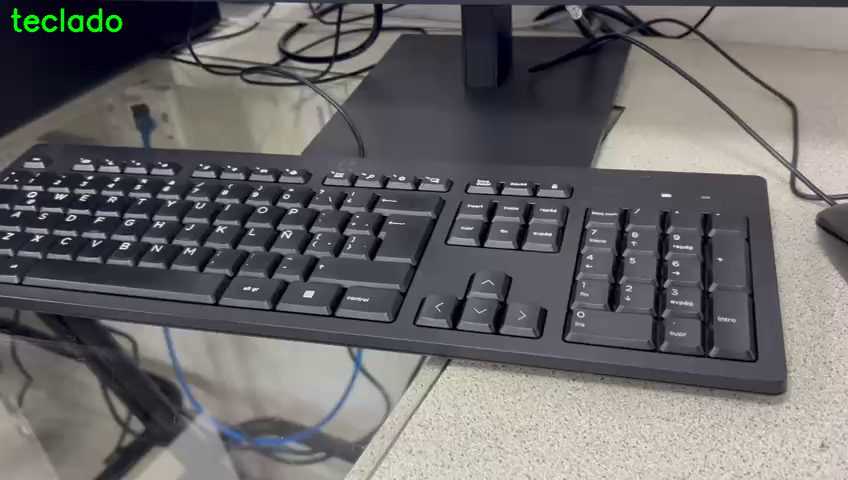

Detected object in the first frame: teclado
Video processing complete.


In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Path to the video file
video_path = '/content/20241196002_teclado.mp4'

# Load the video
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Get video properties
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Video opened successfully. Total frames: {frame_count}, Frame rate: {frame_rate} FPS")

    # Initialize LabelEncoder with the classes used during training
    # Ensure the order of classes is the same as during training
    label_encoder = LabelEncoder()
    # Fit with the unique labels from the labels_array to ensure correctness
    label_encoder.fit(np.unique(labels_array.flatten()))

    print("Processing a single video frame and predicting class...")
    ret, frame = cap.read()

    # If frame is read correctly ret is True
    if ret:
        # Preprocess the frame (resize, grayscale, normalize)
        resized_frame = cv2.resize(frame, (128, 128))
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        normalized_frame = gray_frame / 255.0

        # Reshape the frame for prediction (add batch and channel dimensions)
        processed_frame = np.expand_dims(normalized_frame, axis=0)
        processed_frame = np.expand_dims(processed_frame, axis=-1)

        # Predict the class using the classification model
        predictions = classification_model.predict(processed_frame)

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Decode the predicted class index back to the original label
        predicted_label = label_encoder.inverse_transform([predicted_class_index])

        # Draw the predicted label on the frame
        # Convert the frame back to BGR for drawing
        frame_with_text = cv2.putText(frame, predicted_label[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame with the predicted label
        cv2_imshow(frame_with_text)

        print(f"Detected object in the first frame: {predicted_label[0]}")

    else:
        print("Could not read the first frame.")


    # Release the video capture object
    cap.release()


    print("Video processing complete.")

In [ ]:
classification_model.export("modelo_clasificacion")

Saved artifact at 'modelo_clasificacion'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140241597440720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241597442256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241597443408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241597443216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425654096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425652944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425655824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425656976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425656016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140241425657552: TensorSpec(shape=(), dtype=tf.resource, name=None)
